# Projet Notations de films 

Ceci EST UNE EBAUCHE....

Dans le cadre du Projet Data Science nous avons choisi d'étudier l'appréciation des films par les spectateurs et la presse, à partir de leur notation.

  

Le rapport se décompose de la manière suivante :   

I - Création de la base de données

1) Webscrapping du site Allocine

2) Traitement de la base et création de variables


II - Analyses descriptive des données

1) Analyses générales sur les notes attribuées aux films

2)


III - Modélisation


### importation des librairies et fichiers

In [1]:
# Installation des packages nécessaires au projet             ATTENTION VOIR SI BESOIN D'AUTRES ?
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install lxml
!pip install aiohttp
!pip install nest_asyncio

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [2]:
# Importation des librairies
import csv
import os

# 
import matplotlib.pyplot as plt
import asyncio
import aiohttp
import pandas as pd
from bs4 import BeautifulSoup
import re
import nest_asyncio


# Regression
import statsmodels.api as sm
from statsmodels.formula.api import rlm 

In [3]:
# Importation des fichiers python (contenant des fonctions) crées dans le cadre des 3 parties du projet :

for f in os.listdir('A_Base_de_données'):
    if f.endswith('.py') and f != 'web_scrapping.py': # A gérer !!!!!
        module_name = os.path.splitext(f)[0]
        exec(f"from A_Base_de_données.{module_name} import *")


for f in os.listdir('B_Analyse_descriptive'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from B_Analyse_descriptive.{module_name} import *")


for f in os.listdir('C_Modele'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from C_Modele.{module_name} import *")


## I - Création de la base de données

### Webscrapping AlloCiné

In [ ]:
# Récupération d'une liste de films qui possèdent tous une note moyenne de spectateur et une note moyenn de presse entre l'année .... et l'année .....
base_films = get_base_films(2010, 2023)


# Récupération pour chaque film de différentes caractériques
nest_asyncio.apply()
base_films_enrichie, presse = get_carac_film(base_films)


In [ ]:
# Exportation en CSV => mettre en commentaire lors du rendu final afin que cela soit toujours le même CSV qui soit utilisé par la suite
from pathlib import Path 
filepath = Path('/home/onyxia/work/Projet_Cin-/A_Base_de_données/base_allociné_2010_2023.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
base_films_enrichie.to_csv(filepath)

In [17]:
# Lecture des bases CSV : 

# Base de films : contenant diverses caractéristiques sur les films
base_films = pd.read_csv('A_Base_de_données/base_films_2010_2023.csv')


# Base presse : contenant la note de chaque presse pour chaque film
presse = pd.read_csv('A_Base_de_données/presse_2010_2023.csv')


### Traitement de la base et création de variables

Base presse

In [19]:
# Traduction des notes en numérique (Très bien => 4, etc)
presse_notes = equivalence_notes(presse)
presse_notes.head()

/home/onyxia/work/Projet_Cin-/A_Base_de_données/mise_en_forme.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  notes = dataframe.replace(equivalences)


,identifiant,L'Express,Télérama,Brazil,Les Fiches du Cinéma,Les Inrockuptibles,Le Figaroscope,Cahiers du Cinéma,Le Point,Bande à part,...,Libération,Slate,Voici,Studio Magazine,Studio Ciné Live,Dernières Nouvelles d'Alsace,Le Soir,L'Ecran Fantastique,Culturopoing.com,aVoir-aLire.com
0,173528,3,1,NaN,NaN,1,1.0,1,3,NaN,...,1,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
1,146632,2,2,3.0,NaN,1,5.0,1,4,NaN,...,1,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
2,133588,3,3,NaN,NaN,3,4.0,NaN,3,NaN,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132039,3,4,3.0,NaN,4,3.0,2,5,NaN,...,3,NaN,NaN,NaN,5,NaN,NaN,2.0,NaN,NaN
4,123534,5,3,4.0,NaN,NaN,4.0,NaN,3,NaN,...,NaN,NaN,NaN,NaN,4,NaN,NaN,4.0,NaN,NaN


base films

In [33]:
table_films = base_films

####### Nettoyage et mise en forme

# Conversion des notes en écriture décimale
table_films['spectateur'] = table_films['spectateur'].apply(mise_en_forme_decimale)
table_films['presse'] = table_films['presse'].apply(mise_en_forme_decimale)



####### Créations de variables

# Ajout du genre des réalisateurs (en se basant sur une base de plus de 11 627 prénoms de plusieurs pays dont le genre est mentionné)
table_films = get_genre_individuel(table_films, 'auteur')

# Différence de notation entre spectateur et presse
table_films['diff_notation'] = table_films['spectateur']-table_films['presse']

# Année du film
table_films = get_annee(table_films, 'date')

# Durée du film en minutes
table_films['durée'] = table_films['durée'].astype('string')
table_films['duree_min'] = table_films['durée'].apply(duree_en_minutes)

# Catégorisation de la durée des films
table_films = categorisation_duree(table_films, 'duree_min')
len(table_films)

6684

In [34]:
table_films.head(3)

,genre_ind,titre,identifiant,date,durée,auteur,spectateur,presse,genre1,genre2,...,langues,format_production,couleur,format_audio,format_projection,num_visa,diff_notation,annee,duree_min,duree_cat
0,NaN,Rien à déclarer,173528,26 janvier 2011,1h 48min,Dany Boon,2.4,2.2,Comédie,NaN,...,"Flamand, Français",-,Couleur,-,-,125668,0.2,2011,108.0,100-109
1,m,Les petits mouchoirs,146632,20 octobre 2010,2h 34min,Guillaume Canet,3.6,2.9,Comédie dramatique,NaN,...,Français,-,Couleur,-,-,121 898,0.7,2010,154.0,150-159
2,m,L'Agence tous risques,133588,16 juin 2010,1h 54min,Joe Carnahan,3.2,3.2,Action,Comédie,...,"Anglais, Français, Espagnol, Swahili",-,Couleur,-,-,-,0.0,2010,114.0,110-119


La table finale des films contient les colonnes suivantes : 'genre_ind', 'titre', 'identifiant', 'date', 'durée', 'auteur',
       'spectateur', 'presse', 'genre1', 'genre2', 'genre3', 'release',
       'nationalite', 'date_sortie_dvd', 'date_sortie_bluray',
       'date_sortie_vod', 'type_film', 'budget', 'langues',
       'format_production', 'couleur', 'format_audio', 'format_projection',
       'num_visa', 'diff_notation', 'annee', 'duree_min', 'duree_cat'

## II -  Analyses descriptives

### 1) Analyses descriptives générales des notes des spectateurs en fonction du genre du film

Nous avons à notre disposition une base de **6684** films issus d'Allocinés. Avec pour chaque film la **note moyenne** attribuée par les **spectateurs** ainsi que la note moyenne attribuée par **la presse**. Les notes vont de **1 à 5**.

1) Dans un premier temps, nous pouvons regarder quels sont les types de films les plus appréciés en moyenne par les spectateurs : 

In [35]:
# (A noter que les genres dont nous possédons moins de 30 films ne sont pas pris en compte).
classement_genres_preferes(table_films, 'spectateur')

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.484758,269
Animation,3.340341,352
Aventure,3.213265,392
Drame,3.183932,2533
Policier,3.135354,198
Comédie dramatique,3.082310,407
Science Fiction,3.045161,31
Action,3.044745,628
Thriller,2.951020,147


Les films **Biopic**, d'**Animation** et d'**Aventure** semblent être les plus appréciés par les spectateurs. Tandis que les films de **Comédie**, **Fantastique** ou encore d'**Epouvante-horreur** semblent relativement moins appréciés. 

A noter que les effectifs au sein de chaque genre de films peuvent être assez variables (allant de 31 avec la Science Fiction à plus de 2533 pour les Drames). De ce fait, il peut être intéressant de comparer de manière plus précise les **notes moyennes** attribuées par les **spectateurs** afin de voir si les différences dans la **notation des spectateurs** en fonction du **genre de film** sont significatives ou pas. 

Pour cela, nous pouvons regarder la distribution des notes à l'aide d'un **histogramme**, et réaliser un test **ANOVA** sur les différents groupes. Cette méthode statistique permet de déterminer si au moins une des moyennes parmi les groupes étudiés est significativement différente des autres, en tenant compte de la variabilité au sein et entre les groupes.

Dropdown(description='Genre 1 :', index=12, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aven…

Dropdown(description='Genre 2 :', index=12, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aven…

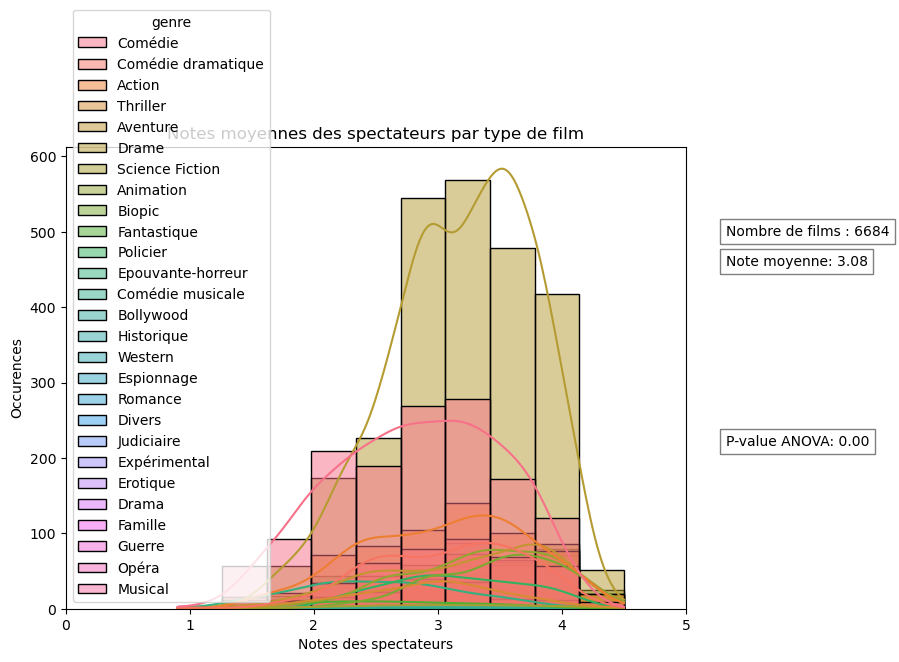

In [36]:
# Histogrammes de la distribution des notes attribuées par les spectateurs en fonction du genre du film
# => Les menus déroulants permettent de sélectionner différents genres à comparer 
# => Les genres dont nous possédons moins de 30 films ne sont pas pris en compte)                         !!!!!!!!!!!!!!!!!!!!!!!!!! COUPER A 50 ?

graphique_genre_film(table_films)  

Une p-value du test d'ANOVA très faible (inférieure aux seuils usuels, et notamment de 5%), indique que la différence de notation des spectateurs entre les genres de films peut être considérée comme significative. En étudiant les différentes distributions de notes en fonction des genres ainsi que les tests ANOVA associés, nous pouvons remarquer les points suivants :


- L'ANOVA sur tous les types de films montre qu'il existe bien des **différences significatives** au sein des groupes (au moins un groupe se distingue des autres), cependant cela ne donne aucune information sur quels sont les groupes statistiquement significatifs. Pour cela, nous pouvons par exemple les comparer deux par deux. 


- Pour certains genres de films qui étaient très proche dans le classement, leur p-value montrent que les différences de notations ne sont pas très significatives (Tels que Policier et Comédie Dramatique avec 0,30), voir même pas du tout significatives (avec des valeurs de p-value supérieures à 0,7, voir proche de 1 (SF et Comédie dramatique, SF et Actions, etc))

- Mais certains genres qui étaient très proches au niveau de la notation moyenne, se retrouvent en fait à avoir des différences de notation qui peuvent être considérées comme statistiquement significatives. C'est notamment le cas du genre **Animation** et **Aventure**, respectivement aux deuxième et troisième places sont significatives au seuil de 10 et 5%.

- Bien sûr, comme attendu, nous remarquons que plus les 2 genres considérés sont éloignés dans le classement, plus la p-value est significative. 

Les diverses ANOVA réalisées laissent supposer que le type de films semblerait avoir une influence sur la note attribuée par les spectateurs.

### 2) D'autres caractéristiques pourraient-elles avoir une influence sur l'appréciation attribuée par les spectateurs ?

De manière similaire à précédemment nous pouvons effectuer un test **ANOVA** sur le **genre du réalisateur** afin de voir s'il existe une différence significative dans les notes moyennes attribuées aux films réalisés par des femmes et aux films réalisés par des hommes.

In [37]:
p_value_anova_h_vs_f(table_films)

'P-value du test ANOVA: 0.102'

Avec une p-value bien supérieure aux seuils habituels de 1, 5 et 10%, nous pouvons dire qu'il ne semble **pas** y avoir de **différence** statistiquement significative entre les notes attribuées par les spectateurs pour des films réalisés par des femmes et des films réalisés par des hommes. 

Nous pouvons aussi nous pencher sur la durée des films, en traçant le boxpolt des notes en fonction de la durée des films (durée qui a été discrétisée en intervalle de 10 minutes) : 

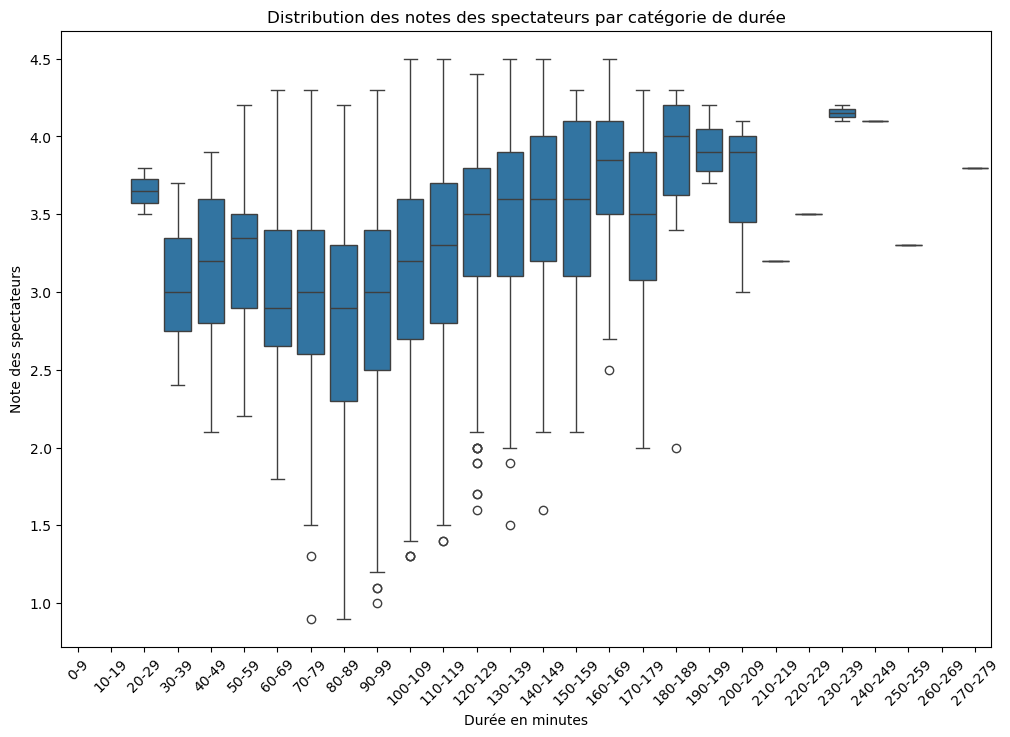

In [16]:
boxplot_duree(table_films, 'duree_cat')

COMMENTAIRES A FINIR <<<<<<<<<<<<<<<>>>>>>>>>>>>>>>

Ajouter une petite visualisation en fonction du nombre de nomination ? <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

### 3) Les préférences des spectateurs sont-elles similaires à celles de la presse ?

Nous avons précédemment regardé le classement des genres de films les plus appréciés par les spectateurs. Comparons maintenant ce classement à celui de la presse :

In [17]:
comparaison_preferences(table_films)

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.484758,269
Animation,3.340341,352
Aventure,3.213265,392
Drame,3.183932,2533
Policier,3.135354,198
Comédie dramatique,3.082310,407
Science Fiction,3.045161,31
Action,3.044745,628
Thriller,2.951020,147


Le classement se ressemble avec un même quatuor en tête, et même genres de films en queue de classement. 
Cependant les notes moyennes des spectateurs semblent tenir globalement sur un intervalle plus large que celui de la presse.

Dropdown(description='Genre :', index=12, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aventu…

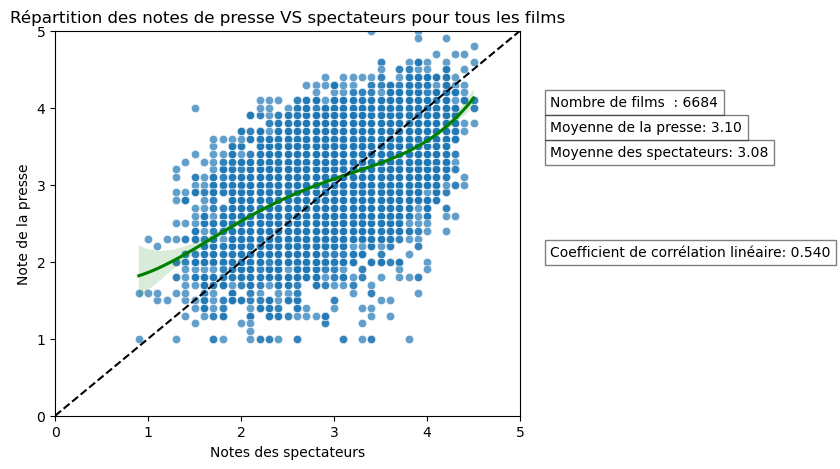

In [18]:
# Nuage de points pour voir les différences de notations entre la presse et les spectateurs
# => 
# => explique rapide le polynôme vert ---------------------------
# =>
graphique_presse_vs_spect(table_films) 

COMMENTAIRES A FINIR =>>>>>>>>>>>>>>>>>>>>>>

Afin d'avoir une analyse plus fine, notamment en terme de budget alloué au film ainsi que le genre du/des réalisateurs nous pouvons agréger à nos films, la base française CNC. Nous perdrons un certains nombre de films, mais en contrepartie cela nous permet d'avoir des variables plus précises pour certaines caractéristiques.

### 4) Le budget alloué et le genre des réalisateurs peuvent-ils influer sur les notes attribuées par la presse et les spectateurs ? (périmètre d'étude réduit aux films français de la base CNC)

### Base CNC : Analyse du type de devis, obtenus par les réalisateurs vs les réalisatrices

Une base du CNC nous donne ce type d'information : les sociétés productrices et distributrices des films, chaînes de télévision partenaires en préachat. Je veux étudier les différences de montant des devis selon le genre du réalisateur.


In [10]:
#Ici, j'importe les données du CNC en utilisant un API.
import requests
import pandas as pd
api_root = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/cnc-production-cinematographique-liste-des-films-agrees/exports/json?limit=-1"
response = requests.get(api_root)
films_cnc_brut = response.json() #je mets tout dans un dico json
print(response.content[:1000])

films_cnc = pd.json_normalize(films_cnc_brut) 
#films_cnc = films_cnc.set_index('visa')

b'[{"visa": "117042", "titre": "BYE BYE BLONDIE", "realisateur": "DESPENTES Virginie", "producteurs": "MASTER MOVIES / RED STAR CINEMA / WILD BUNCH", "devis": 4103906.0, "genre": "Fiction", "eof": null, "rang": "2", "asr": "avant", "payante": null, "clair": null, "nationalite": ["France", "Belgique", "Suisse"], "date": "2010", "decomposition": "France-65 / Belgique-21 / Suisse-14", "aides": ["Sofica"]},{"visa": "127028", "titre": "DE L\'HUILE SUR LE FEU", "realisateur": "BENAMOU Nicolas", "producteurs": "AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / TF1 DROITS AUDIOVISUELS / UGC IMAGES", "devis": 3320336.0, "genre": "Fiction", "eof": null, "rang": "1", "asr": null, "payante": null, "clair": null, "nationalite": ["France"], "date": "2010", "decomposition": "France-100", "aides": ["Sofica", "Cr\\u00e9dit D\'impot"]},{"visa": "124421", "titre": "DES JEUNES GENS MODERNES", "realisateur": "DE MISSOLZ J\\u00e9r\\u00f4me", "producteurs": "ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRODUCTIONS

In [14]:
# Categorisation des films en fonction du devis
films_cnc = categorisation_devis(films_cnc)


# Ajout d'une variable de genres : si il y a plusieurs réalisateurs => on indiquera si il y a au moins une femme
films_cnc = ajout_genre_multiple(films_cnc, 'realisateur')


In [134]:
# Bon plus que 888 non trouvé....
films_cnc['genre_ind'].value_counts()

genre_ind
m                     2535
non trouvé             888
f                      713
m_coréalisé            266
f_coréalisé            106
m,f                     61
f,m                     49
pas de realisateur       2
Name: count, dtype: int64

In [15]:
films_cnc.head()

,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis,genre_ind
0,117042,BYE BYE BLONDIE,[DESPENTES Virginie],MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,None,"[France, Belgique, Suisse]",2010,France-65 / Belgique-21 / Suisse-14,[Sofica],entre 4 et 7 m,f
1,127028,DE L'HUILE SUR LE FEU,[BENAMOU Nicolas],AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot]",entre 2 et 4 m,m
2,124421,DES JEUNES GENS MODERNES,[DE MISSOLZ Jérôme],ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRO...,815248.0,Documentaire,None,2,None,None,None,[France],2010,France-100,[Crédit D'impot],<2 m,m
3,123383,EXERCICE DE L'ETAT (L'),[SCHOELLER Pierre],ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,None,"[France, Belgique]",2010,France-80 / Belgique-20,"[Sofica, Crédit D'impot]",entre 4 et 7 m,m
4,124350,MA PART DU GATEAU,[KLAPISCH Cédric],CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",> à 7 m,m


In [16]:
len(films_cnc)

4620

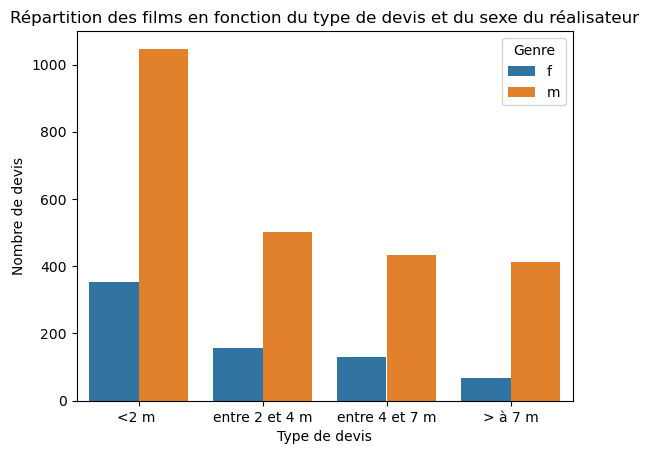

In [17]:

# Filtrer les données pour les modalités 'f' et 'm' de 'genre_ind'
films_cnc_filtered = films_cnc[films_cnc['genre_ind'].isin(['f', 'm'])]

# Créer le barplot avec seaborn
sns.countplot(data=films_cnc_filtered, x='type_de_devis', hue='genre_ind', dodge=True)

# Ajouter des titres et des labels
plt.title('Répartition des films en fonction du type de devis et du sexe du réalisateur')
plt.xlabel('Type de devis')
plt.ylabel('Nombre de devis')
plt.legend(title='Genre')

# Afficher le plot
plt.show()

### Fusion base CNC et base allociné

In [18]:
base_allocine = base_films.drop(columns=['titre'])
base_cnc_agregee = pd.merge(films_cnc, base_allocine,left_on='visa', right_on='num_visa', how='inner')
len(base_cnc_agregee)
base_cnc_agregee

,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,...,date_sortie_vod,type_film,budget,langues,format_production,couleur,format_audio,format_projection,num_visa,prenom
0,117042,BYE BYE BLONDIE,[DESPENTES Virginie],MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,...,21/07/2012,Long métrage,4 500 000 EUR,Français,"35mm, Super 8",Couleur,Dolby Digital,1.85 : 1,117042,virginie
1,127028,DE L'HUILE SUR LE FEU,[BENAMOU Nicolas],AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,...,31/03/2017,Long métrage,-,Français,-,Couleur,-,-,127028,nicolas
2,123383,EXERCICE DE L'ETAT (L'),[SCHOELLER Pierre],ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,...,30/06/2015,Long métrage,-,Français,35mm,Couleur,Dolby SRD,2.35 : 1 Cinemascope,123383,pierre
3,124350,MA PART DU GATEAU,[KLAPISCH Cédric],CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,...,16/07/2011,Long métrage,9 000 000 USD,Français,-,Couleur,-,-,124350,cédric
4,122385,MARQUIS (LE),[FARRUGIA Dominique],FARRUDG ENTERTAINMENT WORLDWIDE / PATHE PRODUC...,8880926.0,Fiction,None,3,None,None,...,21/10/2015,Long métrage,-,Français,-,Couleur,-,-,122385,dominique
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,149721,Sic transit Gloria Mundi,[GUEDIGUIAN Robert],EX NIHILO,4103087.0,Fiction,OUI,3,None,"[C+, Ciné+]",...,01/04/2020,Long métrage,-,Français,-,Couleur,-,-,149721,robert
2160,151502,Tlamess,[EDDINE SLIM Ala],STILL MOVING,788017.0,Fiction,NON,3,None,None,...,18/05/2020,Long métrage,-,ARABIC,-,Couleur,-,-,151502,ala
2161,141793,D'une pierre deux coups,[DELIBA Fejria],CINE SUD PROMOTION,1219623.0,Fiction,None,1,avant,None,...,19/08/2016,Long métrage,-,Français,-,Couleur,-,-,141793,fejria
2162,138716,Irremplaçable,[LILTI Thomas],31 JUIN FILMS / FRANCE 2 CINEMA / LES FILMS DU...,5345262.0,Fiction,None,3,None,"[C+, Ciné+]",...,23/07/2016,Long métrage,-,Français,-,Couleur,-,-,138716,thomas


à noter : dans l'article, ils créent une cinquième catégorie rassemblant "les sociétés de production et les sociétés de distribution qui n’ont produit ou distribué qu’un ou deux longs-métrages d’initiative française sur la période de trois ans étudiée. Cette catégorie 9 regroupe donc des producteurs et des distributeurs qui ont eu une très faible activité sur la période (plusieurs ont eu une courte durée de vie) ou encore des distributeurs liés à des majors américaines pour lesquels la distribution de FIF est une activité marginale. 272 films ont été produits et 70 distribués par de telles sociétés."

Par ailleurs, on peut également faire une typologie en fonction du type de distributeur (voir l'article également).


J'essaie ici de préciser le genre du réalisateur. Dans le cas où le réalisateur est un homme, j'attribue à ma variable genre "m", dans le cas où c'est une femme, j'attribue à ma variable genre "f". Si c'est les deux, "plusieurs réalisateurs".

Je rencontre plusieurs difficultés : déjà j'ai plusieurs réalisateurs par films parfois. J'ai donc essayer de créer une fonction qui me crée une variable par réalisateur (j'ai un petit problème ici). Ensuite l'idée est de créer la variable genre décrite ci-dessus, puis de passer aux analyses.

In [125]:
#Je crée la fonction genre pour les films ayant un unique réalisateur

realisateur_split = films_cnc["realisateur"].str.split(pat='/', expand=True, regex=True)
index_films_uniques = realisateur_split.iloc[:, 1:].applymap(lambda x: pd.isna(x) or x is None).all(axis=1) # Je récupère l'index des films ayant un unique réalisateur
films_uniques = films_cnc.loc[index_films_uniques] # Je crée un dataframe spécifique
films_uniques



/tmp/ipykernel_84937/3215841689.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  index_films_uniques = realisateur_split.iloc[:, 1:].applymap(lambda x: pd.isna(x) or x is None).all(axis=1) # Je récupère l'index des films ayant un unique réalisateur


,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis,genre_ind
0,117042,BYE BYE BLONDIE,[DESPENTES Virginie],MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,None,"[France, Belgique, Suisse]",2010,France-65 / Belgique-21 / Suisse-14,[Sofica],entre 4 et 7 m,f
1,127028,DE L'HUILE SUR LE FEU,[BENAMOU Nicolas],AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot]",entre 2 et 4 m,m
2,124421,DES JEUNES GENS MODERNES,[DE MISSOLZ Jérôme],ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRO...,815248.0,Documentaire,None,2,None,None,None,[France],2010,France-100,[Crédit D'impot],<2 m,m
3,123383,EXERCICE DE L'ETAT (L'),[SCHOELLER Pierre],ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,None,"[France, Belgique]",2010,France-80 / Belgique-20,"[Sofica, Crédit D'impot]",entre 4 et 7 m,m
4,124350,MA PART DU GATEAU,[KLAPISCH Cédric],CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",> à 7 m,m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,132961,Orpheline,[DES PALLIERES Arnaud],CENTRE EUROPEEN CINEMATOGRAPHIQUE RHONE ALPES ...,4629334.0,Fiction,None,3,avant,"[C+, Ciné+]",Arte,[France],2015,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",entre 4 et 7 m,m
4616,140535,Secret d'hiver,[HARTER Vincent],HAKA VISION,1163015.0,Fiction,None,1,None,None,None,"[France, Canada]",2015,France-65 / Canada-35,None,<2 m,m
4617,142256,Sierra nevada,[PUIU Cristi],ALCATRAZ FILMS,1249000.0,Fiction,None,3,None,None,None,"[Roumanie, France, Croatie, Bosnie, Macédoine]",2015,Roumanie-56 / France-12 / Croatie-11 / Bosnie-...,[Aide Régionale],<2 m,m
4618,139974,The Other Side,[MINERVINI Roberto],AGAT FILMS ET CIE,530417.0,Docu,None,3,None,None,Arte,"[France, Italie]",2015,France-57 / Italie-43,None,<2 m,m


In [128]:
films_uniques.shape

(4620, 17)

In [129]:
#J'intègre le genre dans ma base de données : A METTRE DANS LE FICHIER FONCTIONS
def get_genre_individuel(dataframe, colonne, position):
    """ 
    Cette fonction parcourt les colonnes de réalisateurs, détermine le genre de chaque réalisateur
    et ajoute une colonne 'genre' qui indique "m" s'il y a un unique réalisateur masculin, "f" s'il y a une unique réalisatrice,  "f_coréalisé" ou "m_coréalisé" sinon.
    
    Paramètres :
      dataframe : DataFrame
      colonnes_real : list
        Liste des noms de colonnes contenant les prénoms des réalisateurs
      
    Retourne :
    dataframe : DataFrame
        Le DataFrame avec une nouvelle colonne 'genre'.

    """
    base_prenom_genre = base_prenom()
    base_prenom_genre = base_prenom_genre.drop(columns=['04_fréquence'])

    # transformation du prénom en minuscule
    dataframe['prenom'] = dataframe[colonne].str.split().str[position].str.lower()

    base_avec_genre = pd.merge(base_prenom_genre, dataframe, on='prenom', how='inner')
    base_avec_genre_nettoyée = base_avec_genre.drop(labels='prenom', axis='columns')
    return base_avec_genre_nettoyée


In [130]:
#Je crée la variable genre pour cette base
films_uniques_genre = get_genre_individuel(films_uniques, "realisateur", -1)
films_uniques_genre

AttributeError: Can only use .str accessor with string values!

In [13]:
films_uniques_genre.shape

(3180, 18)

Problème : 
Avant emploi de get_genre,, j'avais 4200 observations, là j'en ai + que 3180...

In [136]:
import matplotlib.pyplot as plt
# Création du groupe "genre", et décompte des individus de chaque sous-groupe (male, female) 
g = films_uniques_genre.groupby('genre_ind') 
c_female = g.get_group('f')['type_de_devis'].value_counts() 
c_male = g.get_group('m')['type_de_devis'].value_counts() 

# On extrait les noms des différents types de devis et des différents sexes
dev = films_cnc['type_de_devis'].value_counts().index
gender = films_cnc['genre_ind'].value_counts().index 
pos = np.arange(len(dev)) 
width = 0.35 # épaisseur de chaque bâton 

# Création du diagramme en bâtons (bâtons côte à côte) 
plt.bar(pos - width/2, c_male, width, color='lightsteelblue') 
plt.bar(pos + width/2,c_female, width, color='IndianRed') 
plt.xticks(pos, dev)
plt.xlabel('Type de devis', fontsize=14) 
plt.title('Répartition des films en fonction du type de devis et du sexe du réalisateur',fontsize=15) 
plt.legend(gender,loc=1) 
plt.show() 


NameError: name 'films_uniques_genre' is not defined

## Nettoyage films avec plusieurs réalisateurs (brouillon)

In [ ]:
# Initialisation des DataFrames pour les films avec 1 ou plusieurs réalisateurs
films_cnc_1_réalisateur = pd.DataFrame(columns=['titre', 'realisateur', 'producteurs', 'devis', 'genre', 'eof', 'rang',
                                                 'asr', 'payante', 'clair', 'nationalite', 'date', 'decomposition',
                                                 'aides', 'type_de_devis'])
films_cnc_plusieurs_réalisateurs = pd.DataFrame(columns=['titre', 'realisateur', 'producteurs', 'devis', 'genre', 'eof', 'rang',
                                                         'asr', 'payante', 'clair', 'nationalite', 'date', 'decomposition',
                                                         'aides', 'type_de_devis'])

,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis


In [ ]:
#Cette fonction a pour but de créer une variable genre qui, attribue 'f' aux films réalisés par une femme, 'm' aux films réalisés par un homme, 'f_coréalisé" si le film a été co-réalisé et qu'au moins une femme est dans le projet, sinon "m_coréalisé"
#Pour ce faire, je procède en plusieurs étapes : 

for film in films_cnc: #pour chaque film de ma base
   realisateur_split = films_cnc["realisateur"].str.split(pat='/', expand=True, regex=True)

   for j in range(1,12): #si le film a été réalisé par un unique réalisateur, j'ajoute le film à une base provisoire pour pouvoir appliquer la fonction genre
    if realisateur_split["j"]= None
       films_cnc_1_réalisateur = pd.concat([films_cnc_1_réalisateur, pd.DataFrame([film])], ignore_index=False)
       films_cnc_1_réalisateur['genre']= films_cnc_1_réalisateur['realisateur'].apply(get_genre_prenom)
    else 
    films_cnc_plusieurs_réalisateurs = pd.concat([films_cnc_plusieurs_réalisateurs, pd.DataFrame([film])], ignore_index=False)
    films_cnc_plusieurs_réalisateurs.columns = [f"genre_réalisateur_{i+1}" for i in range(realisateur_split.shape[1])]
    films_cnc_1_réalisateur['genre']= films_cnc_1_réalisateur['realisateur'].apply(get_genre_prenom)
     

    #J'ajoute la variable genre à mes bases
    films_cnc_1_réalisateur_avec_genre = get_genre_individuel(films_cnc_1_réalisateur, 'realisateur', -1)
    
    films_cnc_plusieurs_réalisateurs_final = add_realisateur_columns(films_cnc_plusieurs_réalisateurs)
    films_cnc_plusieurs_réalisateurs_final = get_genre_individuel(????)

    #Je concatène mes deux bases 

return 
  
  films_cnc_1_réalisateur['genre']= films_cnc_1_réalisateur['realisateur'].apply(get_genre_prenom)
  

In [ ]:
def get_genre_prenom(prenom):
    """
    Retourne le genre associé au prénom donné

    """
    # Import de la base prénom
    base_prenom_genre = base_prenom()
    base_prenom_genre = base_prenom_genre.drop(columns=['04_fréquence', 'langage_ind'])

    # Transformer le prénom en minuscule afin de pas avoir de pb de casse avec les majuscules
    prenom_formate = prenom.lower()

    # Recherche du prénom dans la base
    genre = base_prenom_genre[base_prenom_genre['prenom'].str.lower() == prenom_formate]

    if not genre.empty:
        return genre['genre_ind'].values[0]
    else:
        return 'non trouvé'

In [ ]:
#Fonction à enregistrer dans le dossier dédié, fonction qui ajoute des colonnes réalisateurs 
def add_realisateur_columns(df):
    """
   Cette fonction crée une variable par réalisateur (quand ces derniers sont nombreux).
    Elle divise la colonne 'realisateur' par '/' et ajoute une colonne pour chaque réalisateur.
    
    Paramètres :
    df : DataFrame
        Le DataFrame contenant les données avec la colonne 'realisateur'.
   
    Retourne :
    DataFrame avec les nouvelles colonnes pour chaque réalisateur ajoutées.    
    """

    # Création d'un dataframe contenant un realisateur par colonne
    realisateur_split = df["realisateur"].str.split(pat='/', expand=True, regex=True)

    # Renommer les colonnes pour correspondre à "réalisateur_1", "réalisateur_2", etc.
    realisateur_split.columns = [f"réalisateur_{i+1}" for i in range(realisateur_split.shape[1])]

    #Assurer que les index sont en str
    realisateur_split.index = realisateur_split.index.astype(str)
    df.index = df.index.astype(str)
    
    # Fusionner les dataframes
    df_avec_plein_de_real = pd.merge(left= df, right=realisateur_split, left_index=True, right_index=True)
    return df_avec_plein_de_real


### Fusion base CNC et base allociné

Cette fois, j'intègre les notes dans l'analyse de genre.

In [17]:
#Préparation des bases pour le merge 
base_films['num_visa'] = base_films['num_visa'].str.replace(' ', '')
#base_films = base_films.set_index('num_visa')
#base_films.index = base_films.index.astype(str)
#films_uniques_genre.index = films_uniques_genre.index.astype(str)


In [18]:
base_films

,titre,identifiant,date,durée,auteur,spectateur,presse,genre1,genre2,genre3,...,date_sortie_bluray,date_sortie_vod,type_film,budget,langues,format_production,couleur,format_audio,format_projection,num_visa
0,Rien à déclarer,173528,26 janvier 2011,1h 48min,Dany Boon,"2,4","2,2",Comédie,NaN,NaN,...,15/06/2011,15/06/2011,Long métrage,-,"Flamand, Français",-,Couleur,-,-,125668
1,Les petits mouchoirs,146632,20 octobre 2010,2h 34min,Guillaume Canet,"3,6","2,9",Comédie dramatique,NaN,NaN,...,23/02/2011,01/03/2016,Long métrage,17 000 000 EUR,Français,-,Couleur,-,-,121898
2,L'Agence tous risques,133588,16 juin 2010,1h 54min,Joe Carnahan,"3,2","3,2",Action,Comédie,NaN,...,03/11/2010,01/06/2015,Long métrage,110 000 000 USD,"Anglais, Français, Espagnol, Swahili",-,Couleur,-,-,-
3,Shutter Island,132039,24 février 2010,2h 17min,Martin Scorsese,"4,4","3,8",Thriller,NaN,NaN,...,24/06/2010,15/10/2017,Long métrage,80 000 000 USD,"Anglais, Allemand",-,Couleur,-,-,124145
4,Dragons,123534,31 mars 2010,1h 33min,Chris Sanders,"4,3","3,9",Aventure,Animation,Famille,...,02/11/2010,20/05/2016,Long métrage,165 000 000 USD,Anglais,-,Couleur,-,-,124842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6679,Le Petit hérisson dans la brume et autres merv...,311236,5 avril 2023,0h 39min,Yuri Norstein,"3,0","4,3",Animation,Famille,NaN,...,-,-,Long métrage,-,Français,-,Couleur,-,-,2023001466
6680,Monsieur Constant,310862,17 mai 2023,1h 48min,Alan Simon,"3,6","2,3",Comédie dramatique,NaN,NaN,...,-,-,Long métrage,-,Français,-,Couleur,-,-,157660
6681,"Cléo, Melvil et moi",312085,5 juillet 2023,1h 13min,Arnaud Viard,"3,2","3,1",Comédie dramatique,NaN,NaN,...,-,28/05/2024,Long métrage,-,Français,-,N&B,-,-,153767
6682,MMXX,314000,1 novembre 2023,2h 40min,Cristi Puiu,"2,5","2,8",Comédie dramatique,NaN,NaN,...,-,06/02/2024,Long métrage,-,Roumain,-,Couleur,-,-,-


In [19]:
films_uniques_genre

,genre_ind,langage_ind,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis
0,m,"english, french, spanish, biblical",137211,Pasolini,FERRARA Abel,ARTE FRANCE CINEMA / CAPRICCI PRODUCTION,2.97,Fiction,None,3,None,[C+],Arte,"[France, Italie, Belgique]",2014,France-55 / Italie-26 / Belgique-20,[Aide Régionale],<2 m
1,m,"english, french, spanish, biblical",118831,VERTIGE,FERRY Abel,GAUMONT / SOMBRERO FILMS,2373778.00,Fiction,None,1,None,None,None,[France],2009,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",entre 2 et 4 m
2,m,"english, french, spanish, biblical",145924,Music from the films of Abel Ferrera,FERRARA Abel,BATHYSPHÈRE PRODUCTIONS,283898.00,Docu,OUI,3,None,None,None,[France],2017,France-100,[Crédit D'impot],<2 m
3,m,"english, biblical",140039,Fausse route,PASTOLL Abner,SUPERBE FILMS,0.75,Fiction,None,2,None,None,None,"[Grande Bretagne, France]",2014,Grande Bretagne-60 / France-40,[Sofica],<2 m
4,f,english,134221,Papa lumière,LOUEILH Ada,FRANCE 3 CINEMA / LES FILMS DU KIOSQUE,3.24,Fiction,None,1,avant,None,F3,[France],2013,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",<2 m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,m,french,124122,OISEAU (L'),CAUMON Yves,ARTE FRANCE CINEMA / BLUE MONDAY PRODUCTIONS,2230697.00,Fiction,None,3,avant,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",entre 2 et 4 m
3176,m,french,104695,CACHE CACHE,CAUMON Yves,SUNDAY MORNING PRODUCTIONS,1803086.00,Fiction,None,2,avant,None,None,[France],2004,France-100,"[Sofica, Crédit D'impot]",<2 m
3177,m,french,139783,Notre fils,ANGELO Yves,EPITHETE FILMS / TAPIOCA FILMS,3.98,Fiction,None,3,None,[OCS],None,[France],2014,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",<2 m
3178,m,french,127339,PRESIDENT (LE),JEULAND Yves,LA GENERALE DE PRODUCTION AUDIOVISUELLE,330570.00,Documentaire,None,1,après,None,None,[France],2011,France-100,None,<2 m


In [22]:
inner_merge_cnc_allociné = pd.merge(left = films_uniques_genre , right = base_films , how = 'inner' , left_on= "visa", right_on="num_visa")

In [23]:
df_cleaned_columns = result.loc[:, result.isnull().sum() <= 11]

df_cleaned_rows = df_cleaned_columns.loc[df_cleaned_columns.isnull().sum(axis=1) <= 0]

df_cleaned_rows

,genre_ind,langage_ind,visa,titre_x,realisateur,producteurs,devis,genre,eof,rang,...,LCI,Transfuge,CNews,Libération,Voici,Studio Ciné Live,Dernières Nouvelles d'Alsace,L'Ecran Fantastique,Culturopoing.com,aVoir-aLire.com
genre1,,,,,,,,,,,,,,,,,,,,,
0,m,"english, french, spanish, biblical",137211,Pasolini,FERRARA Abel,ARTE FRANCE CINEMA / CAPRICCI PRODUCTION,2.97,Fiction,None,3,...,-,01/05/2015,Long métrage,-,"Anglais, Français, Italien",-,Couleur,-,-,137211
1,f,"french, english",151330,T'as pécho ?,PICAULT Adeline,SCARLETT PRODUCTION / MANDARIN PRODUCTION,3812538.00,Fiction,OUI,1,...,-,28/11/2020,Long métrage,-,Français,-,Couleur,-,-,151330
2,"f,m",biblical,145391,Touch me not,PINTILIE Adina,LES FILMS DE L'ETRANGER,1058526.00,Fiction,NON,2,...,-,01/04/2019,Long métrage,-,"Anglais, Allemand",-,Couleur,-,-,145391
3,m,"italian, spanish",141865,Belle dormant (La),ARRIETA Adolfo,PARAISO PRODUCTION DIFFUSION,1186351.00,Fiction,None,3,...,-,18/05/2017,Long métrage,-,Français,-,Couleur,-,-,141865
4,f,english,131200,Ma famille et le loup (My family and the wolf),GARCIA Adria,FOLIVARI ET NECTARIOUS,5303429.00,Fiction,OUI,2,...,-,11/12/2019,Long métrage,-,Français,-,Couleur,-,-,131200
Comédie dramatique,3.156863,3.055215,3.069498,3.096774,3.345238,2.467949,3.658824,2.742765,3.949640,3.000000,...,3.800000,3.859649,3.914894,3.110526,3.700000,3.065502,3.783784,4.333333,3.470588,3.387640
1543,f,french,129506,HENRI,MOREAU Yolande,CHRISTMAS IN JULY / F COMME FILM / FRANCE 3 CI...,4740703.00,Fiction,None,2,...,-,04/04/2014,Long métrage,-,Français,-,Couleur,-,-,129506
1544,m,jewish,150171,The operative,ADLER Yuval,LE PACTE,5690054.00,Fiction,NON,2,...,04/12/2019,27/11/2019,Long métrage,-,Anglais,-,Couleur,-,-,150171
1545,m,french,124122,OISEAU (L'),CAUMON Yves,ARTE FRANCE CINEMA / BLUE MONDAY PRODUCTIONS,2230697.00,Fiction,None,3,...,-,-,Long métrage,2 000 000 EUR,Français,35mm,Couleur,Dolby SRD,1. 66,124122


In [65]:
resultat = base_films[base_films["titre"] == "Vertige "]
print(resultat)

Empty DataFrame
Columns: [titre, identifiant, date, durée, auteur, spectateur, presse, genre1, genre2, genre3, release, nationalite, date_sortie_dvd, date_sortie_bluray, date_sortie_vod, type_film, budget, langues, format_production, couleur, format_audio, format_projection, num_visa]
Index: []

[0 rows x 23 columns]


df_transposed = df_cleaned_rows.T
df_transposed.head()

In [22]:
from sklearn.preprocessing import StandardScaler  
 
scaler = StandardScaler()  # normalisation utile ou pas ? => bof, puisque variables sont les notes, donc aucun intérêt ?
df_scaled = scaler.fit_transform(df_transposed)

In [23]:
from sklearn.cluster import KMeans
n_clusters = 3

# K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df_transposed['Cluster'] = kmeans.fit_predict(df_scaled)
print(df_transposed)


genre1                          Action  Animation  Aventure    Biopic  \
L'Express                     2.687500   3.650000  3.099099  3.347107   
Télérama                      2.509662   3.476440  2.964286  3.000000   
Les Fiches du Cinéma          2.747801   3.531250  3.246637  3.196172   
Les Inrockuptibles            2.742331   3.392857  2.730769  2.729412   
Le Figaroscope                3.140845   3.640000  3.532258  4.000000   
Cahiers du Cinéma             2.300000   3.370370  2.540230  2.413043   
Le Point                      2.850575   3.777778  3.457447  3.804348   
Le Monde                      2.387597   3.091429  2.680328  2.808219   
20 Minutes                    3.909091   4.189189  4.053571  3.945312   
La Septième Obsession         3.454545   3.636364  3.636364  3.214286   
Elle                          3.442308   4.183673  3.900000  3.833333   
Télé Loisirs                  3.474227   3.933333  3.679012  3.779661   
Sud Ouest                     2.825397   3.647059  

In [24]:
print(df_transposed.groupby('Cluster').mean())

genre1     Action  Animation  Aventure    Biopic   Comédie  \
Cluster                                                      
0        3.001756   3.610975  3.313008  3.473974  3.201998   
1        3.527213   4.010969  3.817406  3.866913  3.716138   
2        2.547593   3.257254  2.814952  2.874615  2.766789   

genre1   Comédie dramatique     Drame  Epouvante-horreur  Policier  \
Cluster                                                              
0                  3.266331  3.446339           2.973078  3.356716   
1                  3.826890  3.859236           3.542097  3.878998   
2                  2.872757  3.060038           2.590611  2.863519   

genre1   Science Fiction  Thriller  
Cluster                             
0               3.266939  3.144851  
1               3.673967  3.619525  
2               2.887798  2.710484  


In [25]:
clusters = df_transposed.groupby('Cluster').groups


for cluster, critiques in clusters.items():
    print(f"Cluster {cluster}: {list(critiques)}")

Cluster 0: ["L'Express", 'Les Fiches du Cinéma', 'Le Figaroscope', 'Le Point', 'La Septième Obsession', 'Sud Ouest', 'Metro', 'Le Figaro', 'La Voix du Nord', 'Ouest France', 'Positif', 'Mad Movies', 'Paris Match', 'La Croix', 'TF1 News', 'Télé 7 Jours', "L'Humanité", 'CinemaTeaser', 'Le Dauphiné Libéré', 'Excessif', 'Charlie Hebdo', 'Ecran Large', 'Le Journal du Dimanche', 'aVoir-aLire.com']
Cluster 1: ['20 Minutes', 'Elle', 'Télé Loisirs', 'Marianne', 'Franceinfo Culture', 'Femme Actuelle', 'Télé 2 semaines', 'Le Parisien', 'Closer', 'Public', 'LCI', 'Transfuge', 'CNews', 'Voici', "Dernières Nouvelles d'Alsace", "L'Ecran Fantastique", 'Culturopoing.com']
Cluster 2: ['Télérama', 'Les Inrockuptibles', 'Cahiers du Cinéma', 'Le Monde', "L'Obs", 'TéléCinéObs', "Chronic'art.com", 'Critikat.com', 'Première', 'Libération', 'Studio Ciné Live']


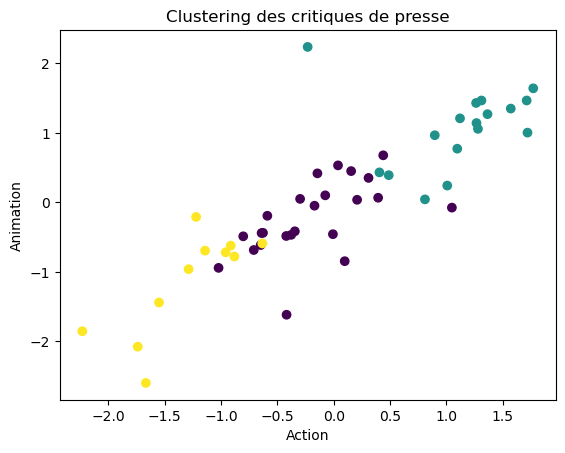

In [26]:
import matplotlib.pyplot as plt

# Visualiser les clusters
plt.scatter(df_scaled[:, 4], df_scaled[:, 5], c=df_transposed['Cluster'], cmap='viridis')
plt.xlabel('Action')
plt.ylabel('Animation')
plt.title('Clustering des critiques de presse')
plt.show()


In [ ]:
# Faire une PCA, serait pratique !